# Exploring Models With Synthetic Data
The advantage of synthetic data is that we know the prior or ground truth and we know exactly how concealed it is. That helps us to determine with certainty that an algorithm is per se capable of discovering the ground truth. If an algorithm fails on the easy task of learning from synthetic data, then it won't be good in real life. The opposite, unfortunately, is not true.

In [1]:
%matplotlib inline

import sys

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column as fc
from tools import print_progress, array_in

## Generating Noisy Samples From A Well-Known Ground Truth

In [2]:
# create a function of x that returns random samples around a*x+b
def make_lin(a, b, rnd):
    def _f_a(x):
        mu = a*x + b
        return rnd(mu)
    return _f_a

---
Two linear but noisy signals:

In [3]:
f_a = make_lin(2, 1, lambda mu: np.random.normal(loc=mu, scale=1.0))
f_b = make_lin(-.5, -1.5, lambda mu: np.random.normal(loc=mu, scale=1.0))

---
A look at one of the signals:

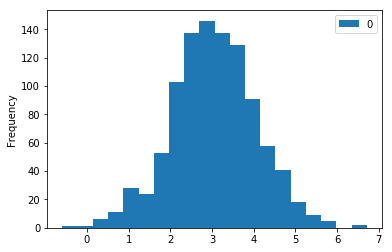

In [4]:
df = pd.DataFrame([f_a(1) for i in range(1000)])
df.plot.hist(bins=20);

---
Now we create a data set/frame representing $f_a(x)+f_b(y)$ as a random variable that depends on random variables $x$ and $y$

In [5]:
def create_data_frame_v1(size):
    x_data = np.random.uniform(high=5, low=-5, size=size)
    y_data = np.random.uniform(high=5, low=-5, size=size)
    f_data = f_a(x_data) + f_b(y_data)
    f_perf = -.5 * y_data - 1.5 + 2 * x_data + 1
    df = pd.DataFrame({'x': x_data, 'y': y_data, 'f': f_data, 'p': f_perf})
    return df

In total, this is equivalent to saying that the ground truth is:

$$ f(x, y) = 2x - \frac{1}{2} y - \frac{1}{2} $$


In [6]:
NUM_RECORDS = 10000

In [7]:
df_train = create_data_frame_v1(NUM_RECORDS)
df_train[:5]

,f,p,x,y
0,-7.212584,-7.646901,-4.448781,-3.501323
1,6.482974,7.485242,4.366242,1.494483
2,-2.321251,-1.696379,0.010224,2.433653
3,10.904092,10.152548,4.517467,-3.235226
4,9.184109,9.326299,4.134234,-3.115663


## Building A Linear Regressor From Scratch With Tensorflow
Let's train a self-made tensorflow linear regressor with the synthetic data to see whether it finds the coefficients above

In [8]:
try:
    sess.close()
except:
    print("OK. Was already closed or didn't exist. That's fine.")
    
sess = tf.InteractiveSession()

OK. Was already closed or didn't exist. That's fine.


The learning rate

In [9]:
lr = .01

---
### Creating The Tensorflow Graph

In [11]:
class Linear():
    def __init__(self, x_dim, lr):

        # Variables for the parameters: weights M and bias b
        self.M = tf.Variable(tf.zeros(shape=(1, x_dim)))
        self.b = tf.Variable(0.)

        # Placeholders for x and labels
        self.x = tf.placeholder(shape=(x_dim,None), dtype=tf.float32)
        self.lbls = tf.placeholder(shape=(1,None), dtype=tf.float32)

        # The prediction and the distance (loss)
        self.f = tf.matmul(self.M, self.x) + self.b
        self.d = tf.losses.mean_squared_error(self.lbls, self.f)

        # The gradients
        self.nM = tf.gradients(self.d, self.M)
        self.nb = tf.gradients(self.d, self.b)

        # The optimizers
        self.aM = tf.assign_add( self.M, tf.multiply(self.nM[0],-lr))
        self.ab = tf.assign_add( self.b, tf.multiply(self.nb[0], -lr))

        # The initializer
        self.init = tf.global_variables_initializer()
    
    def train(self, sess, x_data, labels_data, num_steps):        
        sess.run(self.init)
        for i in range(num_steps):
            _, dist, _, _, _, _ = sess.run([self.f, self.d, self.nM, self.nb, self.aM, self.ab], 
                                           feed_dict = {self.x: x_data, self.lbls: labels_data})
            print_progress("- Loss: {}", dist)
        return dist
    
    def predict(self, sess, x_data):
        pred = sess.run(self.f, feed_dict={self.x: x_data})
        return pred

---
### Perform The Training And Examine The Results

In [12]:
input_data = [list(df_train['x']), list(df_train['y'])]
lbls_data = [list(df_train['f'])]

In [13]:
linear1 = Linear(x_dim=2, lr=0.01)
linear1.train(sess, input_data, lbls_data, 1000)

- Loss: 2.01935839653

2.0193584

We expect the parameters to be close to $2, -0.5, -0.5$:

In [14]:
sess.run([linear1.M, linear1.b])

[array([[ 2.010115  , -0.50174767]], dtype=float32), -0.48766184]

---
Now the tensor f represents the hypothesis. Let's evaluate it with some fresh test data

In [18]:
df_test = create_data_frame_v1(size=10000)
test_data = [list(df_test['x']), list(df_test['y'])]

In [19]:
predictions = linear1.predict(sess=sess, x_data=test_data)

In [20]:
df_test['predictions'] = predictions[0]
df_test[:10]

,f,p,x,y,predictions
0,-0.785405,-1.063593,0.108922,1.562874,-1.052884
1,-3.988941,-2.660188,-1.344718,-1.058495,-2.659602
2,-4.377409,-4.578748,-1.006018,4.133424,-4.583809
3,13.406679,9.873655,4.431079,-3.022996,9.936096
4,-3.250212,-3.087043,-0.424141,3.477524,-3.085073
5,2.511145,6.415450,2.491810,-3.863660,6.459745
6,-6.665805,-6.964906,-3.560071,-1.310474,-6.986287
7,9.475980,9.616496,4.037045,-4.084812,9.676807
8,-8.172631,-9.248996,-4.065293,1.236819,-9.279940
9,6.570288,7.719288,3.646667,-1.851907,7.771748


We can see without surprise that the predictions are typically closer to the ground truth than to the noisy signal. This means we have enough data to average out the noise and reveal the ground truth. A look at the distribution of the errors reveals pure noise around 0. That's typically a good sign that our network has understood the data.

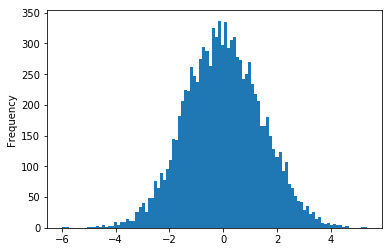

In [22]:
df_errors = df_test['f'] - df_test['predictions']
df_errors.plot.hist(bins=100);

## The Tensorflow LinearRegressor Estimator
Now we'll reproduce this with the high-level estimator API. Surprisingly, the calculations here take much longer than in the basic approach above

In [23]:
input_fn = tf.estimator.inputs.pandas_input_fn(df_train, shuffle=True, num_epochs=100, y=df_train['f'], batch_size=NUM_RECORDS)
feature_columns = [
    fc.numeric_column('x', dtype=tf.float32),
    fc.numeric_column('y', dtype=tf.float32)
]
config = tf.estimator.RunConfig(log_step_count_steps=5)

In [24]:
regressor = tf.estimator.LinearRegressor( feature_columns=feature_columns, config=config )

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8a2f753e50>, '_model_dir': '/tmp/tmpMmRoCE', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 5, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}


---
Perform the training on the regressor

In [25]:
regressor.train(input_fn)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpMmRoCE/model.ckpt.
INFO:tensorflow:loss = 386943.2, step = 1
INFO:tensorflow:global_step/sec: 21.3454
INFO:tensorflow:loss = 187972.67, step = 6 (0.235 sec)
INFO:tensorflow:global_step/sec: 24.5462
INFO:tensorflow:loss = 126301.125, step = 11 (0.204 sec)
INFO:tensorflow:global_step/sec: 25.2797
INFO:tensorflow:loss = 91265.88, step = 16 (0.198 sec)
INFO:tensorflow:global_step/sec: 22.2811
INFO:tensorflow:loss = 69757.305, step = 21 (0.224 sec)
INFO:tensorf

---
### Comparing The Results

In [31]:
input_fn_test = tf.estimator.inputs.pandas_input_fn(df_test, shuffle=False)

In [32]:
generator = regressor.predict(input_fn_test)

In [33]:
pred_estimator = [f['predictions'][0] for f in generator]
df_test['pred_estimator'] = pred_estimator
df_test[:10]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpMmRoCE/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


,f,p,x,y,predictions,pred_estimator
0,-0.785405,-1.063593,0.108922,1.562874,-1.052884,-1.060937
1,-3.988941,-2.660188,-1.344718,-1.058495,-2.659602,-2.586835
2,-4.377409,-4.578748,-1.006018,4.133424,-4.583809,-4.526997
3,13.406679,9.873655,4.431079,-3.022996,9.936096,9.679969
4,-3.250212,-3.087043,-0.424141,3.477524,-3.085073,-3.061683
5,2.511145,6.415450,2.491810,-3.863660,6.459745,6.313105
6,-6.665805,-6.964906,-3.560071,-1.310474,-6.986287,-6.788001
7,9.475980,9.616496,4.037045,-4.084812,9.676807,9.442366
8,-8.172631,-9.248996,-4.065293,1.236819,-9.279940,-9.051394
9,6.570288,7.719288,3.646667,-1.851907,7.771748,7.560855


---
## Learning From Categorical Data

Let's now assume that the ground truth is a complex function of the week day and time of day. That could happen e.g., if you measure the humidity and fail to realize that your sensor is near a dry-cleaner's. Let's assume the dry-cleaner's have peek hours on Mon, Tue, Wed from 18:00h to 21:00 and Fri, Sat from 14:00h to 16:00h. During those hours humidity is significantly higher due to the steam produced there. 

First, let's create a dataset that reflects that situation. Day of week and hour of day shall be represented by categorical data. 

In [34]:
NUM_RECORDS = 1000

In [51]:
# create a function of x that returns random samples around a constant, if the hour of week 
conditions = np.array([
    (0, 18), (0, 19), (0, 20), (0, 21), # Mondays
    (1, 18), (1, 19), (1, 20), (1, 21), # Tuesdays
    (2, 18), (2, 19), (2, 20), (2, 21), # Wednesdays
    # closed on Thursdays
    (4, 14), (4, 15), (4, 16),          # Fridays
    (5, 14), (5, 15), (5, 16)           # Saturdays
    # closed on Sundays
    ])

def make_noisy_amplitude_function(amplitude):
    def _f(c1, c2):
        zipped = np.array(zip(c1,c2))
        res = array_in(zipped, conditions)        
        return res * (np.random.normal( 0 * res, .2 ) + amplitude)
    return _f

In [52]:
def create_data_frame_v2(size, amplitude=5.0):
    x_data = np.random.uniform(high=5, low=-5, size=size)
    y_data = np.random.uniform(high=5, low=-5, size=size)
    dow_data = np.random.randint(7, size=size)
    hod_data = np.random.randint(24, size=size)
    f_data = f_a(x_data) + f_b(y_data)
    
    f_special = make_noisy_amplitude_function(amplitude)(dow_data, hod_data)

    f_total = f_data + f_special
    f_perf = -.5 * y_data - 1.5 + 2 * x_data + 1
    df = pd.DataFrame({'x': x_data, 'y': y_data, 'dow': dow_data, 'hod': hod_data, 'f_orig': f_data, 'p': f_perf, 'special': f_special, 'f': f_total})
    return df

In [65]:
df_train_v2 = create_data_frame_v2(size = NUM_RECORDS, amplitude=10.0)
df_train_v2[:20]

,dow,f,f_orig,hod,p,special,x,y
0,2,0.252364,0.252364,14,-1.345822,0.000000,-0.926230,-2.013277
1,6,2.521157,2.521157,11,1.406787,0.000000,0.711581,-0.967250
2,0,1.463014,-8.351817,19,-7.934377,9.814831,-4.843842,-4.506612
3,1,-0.283874,-0.283874,11,1.098578,0.000000,1.831774,4.129941
4,3,-10.981873,-10.981873,9,-7.504628,0.000000,-2.768352,2.935850
5,0,-1.775622,-11.738721,21,-10.923140,9.963099,-4.209076,4.009976
6,6,4.818554,4.818554,19,3.351437,0.000000,1.939211,0.053969
7,4,-2.686177,-2.686177,18,0.257614,0.000000,-0.469166,-3.391890
8,1,-8.646447,-8.646447,10,-10.006795,0.000000,-3.894694,3.434814
9,2,16.986018,6.966146,21,6.500303,10.019872,2.704407,-3.182979


---
Now we'll try do develop an algorithm that's able to identify this particular pattern. Our assumption that it is particular hours on particular days makes this problem a candidate for the categorical features 'hour of day' and 'day of week'. Hence, in a first step, let's take those two features into account. We begin once more with a self-made algorithm. Below is the code that we hade previously, only this time augmented by the 24 + 7 new input features from the categorical columns

### Concatenate the numerical features with the categorical weekdays and hours

In [66]:
ordinals = list(df_train_v2['dow'])
one_hot_dows = np.transpose(np.eye(7)[ordinals])
one_hot_dows[:7,:10]

array([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [67]:
ordinals = list(df_train_v2['hod'])
one_hot_hods = np.transpose(np.eye(24)[ordinals])

In [68]:
input_numerical = [list(df_train_v2['x']), list(df_train_v2['y'])]
lbls_data = [list(df_train_v2['f'])]
input_data = np.append(input_numerical, one_hot_dows, axis=0)
input_data = np.append(input_data, one_hot_hods, axis=0)
print("shapes: {} + {} + {} = {}".format(np.shape(input_numerical), np.shape(one_hot_dows), np.shape(one_hot_hods), np.shape(input_data)))

shapes: (2, 1000) + (7, 1000) + (24, 1000) = (33, 1000)


---
### Create the network and start the training

In [69]:
NUMERICAL_DIM = 2 # namely x and y
WEEKDAY_DIM = 7 # obviously
HOUR_OF_DAY_DIM = 24
X_DIM = NUMERICAL_DIM + WEEKDAY_DIM + HOUR_OF_DAY_DIM

In [70]:
linear2 = Linear(X_DIM, .01)
linear2.train(sess, input_data, lbls_data, 1000)

- Loss: 8.76392936707

8.763929

That loss is significantly larger than the one that we experienced in the simple case. So either the signal/noise ratio is worse (we know it isn't) or there's some signal in the data that we don't recognize yet. 

---
Predictions on a large test set to get sufficient statistics

In [71]:
df_test_v2 = create_data_frame_v2(size = 20000, amplitude=10)

ordinals = list(df_test_v2['dow'])
one_hot_dows = np.transpose(np.eye(7)[ordinals])

ordinals = list(df_test_v2['hod'])
one_hot_hods = np.transpose(np.eye(24)[ordinals])

input_numerical = [list(df_test_v2['x']), list(df_test_v2['y'])]
test_data = np.append(input_numerical, one_hot_dows, axis=0)
test_data = np.append(test_data, one_hot_hods, axis=0)

In [72]:
pred = linear2.predict(x_data=test_data, sess=sess)
df_test_v2['predicted'] = pred[0]
df_test_v2[['f', 'p', 'predicted', 'special']][:10]

,f,p,predicted,special
0,7.412187,9.135580,10.745915,0.000000
1,-2.634105,-2.188982,-2.473977,0.000000
2,5.752271,-3.358464,0.010306,9.875978
3,2.873469,1.676607,2.894675,0.000000
4,-6.779717,-5.831125,-6.354161,0.000000
5,-5.376840,-4.666063,-3.840397,0.000000
6,10.821125,9.426605,9.424401,0.000000
7,1.754152,0.392042,0.193839,0.000000
8,-10.724510,-11.780829,-11.405705,0.000000
9,5.809926,5.291529,4.997434,0.000000


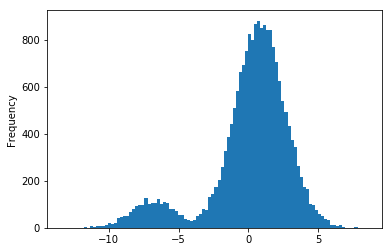

In [74]:
df_errors = df_test_v2['predicted'] - df_test_v2['f']
df_errors.plot.hist(bins=100);

We can see from the error distribution that there's a skew towards larger errors. This is almost certainly a hint that our data contains structure that we didn't discover yet. This distribution is telling: For the majority of the data - the large bump - we have a tendency to over-predict. For some minority though we significantly under-predict. This is a typical sign that the linear regression is finding a weak compromise between two distinct and somehow unrelated distributions that make up our total input data.

Obviously, simply adding the categorical features didn't allow the network to learn the specific characteristic, namely the "and" relationship like in: "The humidity is higher, when it's Wednesday *and* it's 18:00h". Feature crossings and embeddings to the rescue.